In [50]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from string import punctuation
from collections import Counter
import scipy as sp
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
np.random.seed(42)

[nltk_data] Downloading package stopwords to /home/eugene/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/eugene/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/eugene/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Тематическое моделирование (истории из прода).

## Загрузка данных

In [51]:
data = pd.read_json('pycharm_issues.json', lines=True)
data

,idReadable,created,summary,description,Affected versions
0,PY-22135,1483471995465,"""Parameter foo unfilled"": false positives for ...","I'm getting false ""Incorrect call argument"" in...",[2016.3]
1,PY-22143,1483528763930,Python Extract Superclass: Incorrect Order of ...,"When extracting superclasses, if extractions i...",[2016.3]
2,PY-22145,1483545972098,Inspection does not report 'Unresolved Referen...,If a variable is deleted using the `del` state...,[2016.2]
3,PY-22149,1483572086024,ipython notebook clear_output() not working,"Below code should print only once ""Hellow Worl...",[]
4,PY-22128,1483387969625,False negative: no error for round brackets in...,I believe it's rather a common typo to use rou...,[2017.1]
...,...,...,...,...,...
22009,PY-51597,1636879129851,Intellij don't recognize python3 installed by ...,"\n\nIU-212.5457.46, JRE 11.0.12+7-b1504.40x64 ...",[]
22010,PY-51594,1636908525899,url tag in django template that uses filters o...,When using the {% url %} tag in a Django templ...,[]
22011,PY-51588,1636866008572,Variable incorrectly marked as used,"Hi, in this example, tha variable 'idocking' i...",[]
22012,PY-51595,1636912616563,Warn on invalid iterable unpack,```python\nimport time\n\ndef foo() -> float:\...,[2021.2]


Для анализа будем использовать только summary каждого issue, поэтому вытащим их в отдельный массив. Также сохраним маски для двух интересуемых нас версий PyCharm.

In [52]:
summaries = data.summary.values
affects2 = data["Affected versions"].apply(lambda x: '2020.2' in x).values
affects3 = data["Affected versions"].apply(lambda x: '2020.3' in x).values

## Обработка данных

Разобъем каждое summary на токены и удалим все stopwords и пунктуацию. Также в качестве stopwords будем рассматривать такие слова, как pycharm, python и другие наиболее часто встречающиеся слова, не помогающие определить тему сообщения.

In [53]:
sw = set(stopwords.words('english'))
sw.update(['pycharm', 'python', "n't", 'doe'])
punc = set(punctuation)
punc.update(['``', "''"])
lematizer = nltk.stem.WordNetLemmatizer()

In [54]:
summaries = [nltk.tokenize.word_tokenize(summary) for summary in summaries]
summaries = [[lematizer.lemmatize(token.strip().lower()) for token in summary] for summary in summaries]
summaries = [[token for token in summary if token not in punc and token not in sw] for summary in summaries]

Из оставшихся слов составим словарь.

In [55]:
words = []
for line in summaries:
    words.extend(line)
words = list(set(words))
word_index = dict()
for i, word in enumerate(words):
    word_index[word] = i

Для каждого сообщения запишем, сколько раз в нем встречается каждое слово. Матрица получится большая и разреженная, поэтому переведем её в sparse matrix.

In [56]:
X = np.zeros((len(summaries), len(words)))
for i, summary in enumerate(summaries):
    for word in summary:
        X[i, word_index[word]] += 1
X = sp.sparse.coo_matrix(X)

## Обучение модели и визуализация

Обучим LDA на получившейся матрице. n_topics я увеличивал, пока результаты не стали хотя бы как-то интерпретироваться.

In [67]:
n_topics = 15
lda = LatentDirichletAllocation(n_topics, max_iter=20, random_state=1, verbose=1, evaluate_every=5, n_jobs=8)
X_topics = lda.fit_transform(X)
topics_words = lda.components_

iteration: 1 of max_iter: 20
iteration: 2 of max_iter: 20
iteration: 3 of max_iter: 20
iteration: 4 of max_iter: 20
iteration: 5 of max_iter: 20, perplexity: 2524.1849
iteration: 6 of max_iter: 20
iteration: 7 of max_iter: 20
iteration: 8 of max_iter: 20
iteration: 9 of max_iter: 20
iteration: 10 of max_iter: 20, perplexity: 2298.0748
iteration: 11 of max_iter: 20
iteration: 12 of max_iter: 20
iteration: 13 of max_iter: 20
iteration: 14 of max_iter: 20
iteration: 15 of max_iter: 20, perplexity: 2252.0000
iteration: 16 of max_iter: 20
iteration: 17 of max_iter: 20
iteration: 18 of max_iter: 20
iteration: 19 of max_iter: 20
iteration: 20 of max_iter: 20, perplexity: 2237.1023


Средние частоты топиков в двух версиях pycharm:

In [68]:
X_topics_2 = X_topics[affects2].sum(axis=0)
X_topics_3 = X_topics[affects3].sum(axis=0)

Наиболее втречаемые слова в каждом топике:

In [69]:
topics = []
for topic in topics_words:
    indices = topic.argsort()[:-8:-1]
    topics.append([words[index] for index in indices])

Визуализация всего этого:

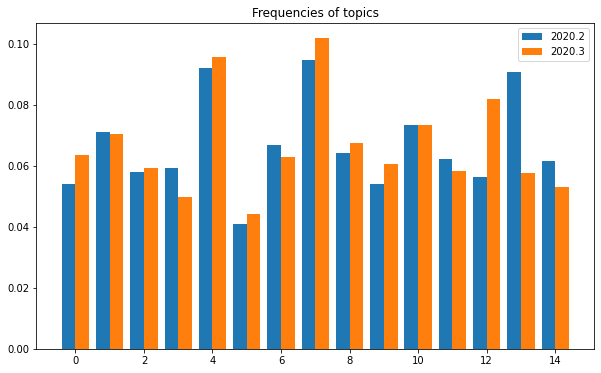

0th topic: error, working, version, syntax, highlighting, update, message
1th topic: project, file, new, open, setting, freeze, window
2th topic: line, string, expected, instead, wrong, literal, comment
3th topic: debugger, django, exception, stop, breakpoints, step, debugging
4th topic: type, hint, incorrect, usage, function, support, return
5th topic: environment, http, web, feedback, reference, file, slow
6th topic: code, completion, process, terminal, inspection, icon, variable
7th topic: false, class, method, positive, argument, function, warning
8th topic: test, run, configuration, directory, module, file, pytest
9th topic: debug, shortcut, file, work, keyboard, menu, move
10th topic: interpreter, remote, server, project, ssh, docker, docker-compose
11th topic: window, view, template, tool, variable, feature, data
12th topic: package, import, module, install, installed, using, even
13th topic: console, jupyter, notebook, cell, output, preview, failed
14th topic: path, find, docke

In [70]:
plt.figure(figsize=(10, 6))
plt.title('Frequencies of topics')
plt.bar(range(n_topics), X_topics_2 / sum(X_topics_2), align='edge', width=-0.4, label='2020.2')
plt.bar(range(n_topics), X_topics_3 / sum(X_topics_3), align='edge', width=0.4, label='2020.3')
plt.legend()
plt.show()
for i, topic in enumerate(topics):
    print(f'{i}th topic:', ', '.join(topic))

# Интерпретация результатов

По гистограмме видно, что в версии 2020.2 среди топиков выделялись три наиболее встречаемых: 4, 7, 13. Судя по наиболее встречаемым словам, можно предположить, о чем эти топики:

(4) неверные подсказки, связанные с использованием функций (например, возвращаемый тип),

(7) ложные предупреждения, связанные с работой с классами и методами,

(13) ошибки в работе с jupyter notebook. 

Разница с релизом 2020.3 небольшая, но наиболее заметна в топиках 12 и 13. Похоже, что в этом релизе исправили работу с jupyter notebook, однако появились проблемы с импортированием установленных модулей.
